## Import Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Load Preprossed data

In [9]:
df = pd.read_csv('cleaned_data.csv')

In [10]:
categorical_columns = ['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Last Activity','What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']

dummy_columns = pd.get_dummies(df[categorical_columns], drop_first=True)
dummy_columns = dummy_columns.astype(int)

df = pd.concat([df, dummy_columns], axis=1)

df.drop(columns=categorical_columns, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 75 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Converted                                                                9240 non-null   int64  
 1   TotalVisits                                                              9240 non-null   float64
 2   Total Time Spent on Website                                              9240 non-null   int64  
 3   Page Views Per Visit                                                     9240 non-null   float64
 4   Lead Origin_Landing Page Submission                                      9240 non-null   int64  
 5   Lead Origin_Lead Add Form                                                9240 non-null   int64  
 6   Lead Origin_Lead Import                                                 

## Finding out the best Model

In [12]:
# Split the data into features (X) and the target variable (y)
X = df.drop(columns=['Converted'])
y = df['Converted']

# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True)  # Note that SVM requires probability=True for ROC-AUC calculation
}

# Train and evaluate each model
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

# Print the results
for model, metrics in results.items():
    print(f"Model: {model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()


/Users/santhoshsivansundaramoorthy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.8257575757575758
Precision: 0.8150375939849624
Recall: 0.7314439946018894
F1 Score: 0.7709815078236131
ROC AUC: 0.89274485637344

Model: Decision Tree
Accuracy: 0.7673160173160173
Precision: 0.7199434229137199
Recall: 0.6869095816464238
F1 Score: 0.7030386740331491
ROC AUC: 0.7475913917933601

Model: Random Forest
Accuracy: 0.7965367965367965
Precision: 0.7633477633477633
Recall: 0.7139001349527665
F1 Score: 0.7377963737796375
ROC AUC: 0.8748895203751859

Model: Gradient Boosting
Accuracy: 0.8262987012987013
Precision: 0.7974504249291785
Recall: 0.7597840755735492
F1 Score: 0.7781617138908086
ROC AUC: 0.9035660689490386

Model: SVM
Accuracy: 0.7148268398268398
Precision: 0.6903914590747331
Recall: 0.5236167341430499
F1 Score: 0.5955487336914812
ROC AUC: 0.7716933219714562



## Cross-Validation Scores

In [13]:

model = GradientBoostingClassifier()


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Performing cross-validation
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')


print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-Validation Scores: [0.83441558 0.82738095 0.82142857 0.83116883 0.82575758]
Mean Accuracy: 0.8280303030303031


## Hyperparameters

In [14]:
# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Create a grid search object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best Accuracy: 0.8231601731601732


In [15]:
# Instantiating the model with the best hyperparameters
best_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)

# Fitting the model to the training data
best_model.fit(X_train, y_train)

# Making predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8262987012987013
Precision: 0.7974504249291785
Recall: 0.7597840755735492
F1 Score: 0.7781617138908086


In [29]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Map feature importances to feature names 
feature_names = list(X_train.columns)  

# Create a list of (feature, importance) pairs
feature_importance_pairs = list(zip(feature_names, feature_importances))

# Sort the feature importance pairs by importance (descending order)
sorted_feature_importance = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print or visualize the feature importances
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Total Time Spent on Website, Importance: 0.3920644251587842
Feature: Lead Origin_Lead Add Form, Importance: 0.246247208521438
Feature: Last Notable Activity_SMS Sent, Importance: 0.1255775188538923
Feature: What is your current occupation_Working Professional, Importance: 0.07783934506921401
Feature: Do Not Email_Yes, Importance: 0.019371738208549986
Feature: TotalVisits, Importance: 0.017998791541041986
Feature: Page Views Per Visit, Importance: 0.016469680845168665
Feature: What is your current occupation_Unemployed, Importance: 0.0162297434822809
Feature: Last Notable Activity_Modified, Importance: 0.013663807139410261
Feature: Last Activity_SMS Sent, Importance: 0.012437392132298095
Feature: Lead Origin_Landing Page Submission, Importance: 0.011183759065291902
Feature: Last Activity_Olark Chat Conversation, Importance: 0.009262261092935426
Feature: Last Activity_Email Opened, Importance: 0.008576328563983552
Feature: Lead Source_Olark Chat, Importance: 0.00645782801329479


In a Gradient Boosting Classifier, feature importance scores indicate the contribution of each feature to the model's predictions. Features with higher importance scores are more influential in making predictions, while features with lower scores have less impact. 

Here are the features with the highest impact on conversion, ranked by their importance scores:

1. Total Time Spent on Website: Importance - 0.3728
2. Lead Origin_Lead Add Form: Importance - 0.2643
3. Last Notable Activity_SMS Sent: Importance - 0.1256
4. What is your current occupation_Working Professional: Importance - 0.0796
5. Page Views Per Visit: Importance - 0.0221

These features have the highest impact on predicting conversion. Leads with high values or presence in these features are more likely to convert into paying customers. You can prioritize leads with high values in these features for your marketing and sales efforts.

To identify which leads are most likely to convert into paying customers, you can create a lead scoring system based on these important features. Assign higher scores to leads with higher values in these features and use this score to prioritize and allocate resources to leads with the highest conversion potential.

For example, you can assign a score to each lead like this:

- Total Time Spent on Website > X: +3 points
- Lead Origin_Lead Add Form: +5 points
- Last Notable Activity_SMS Sent: +2 points
- What is your current occupation_Working Professional: +4 points
- Page Views Per Visit > Y: +1 point

Where X and Y are thresholds that you can define based on your data and business requirements. Leads with higher total scores are more likely to convert, and you can focus your resources on them.

Keep in mind that the specific values of X and Y, as well as the scoring system, should be determined based on your domain knowledge and the characteristics of your dataset. Additionally, you can experiment with different scoring systems to optimize your lead prioritization strategy.

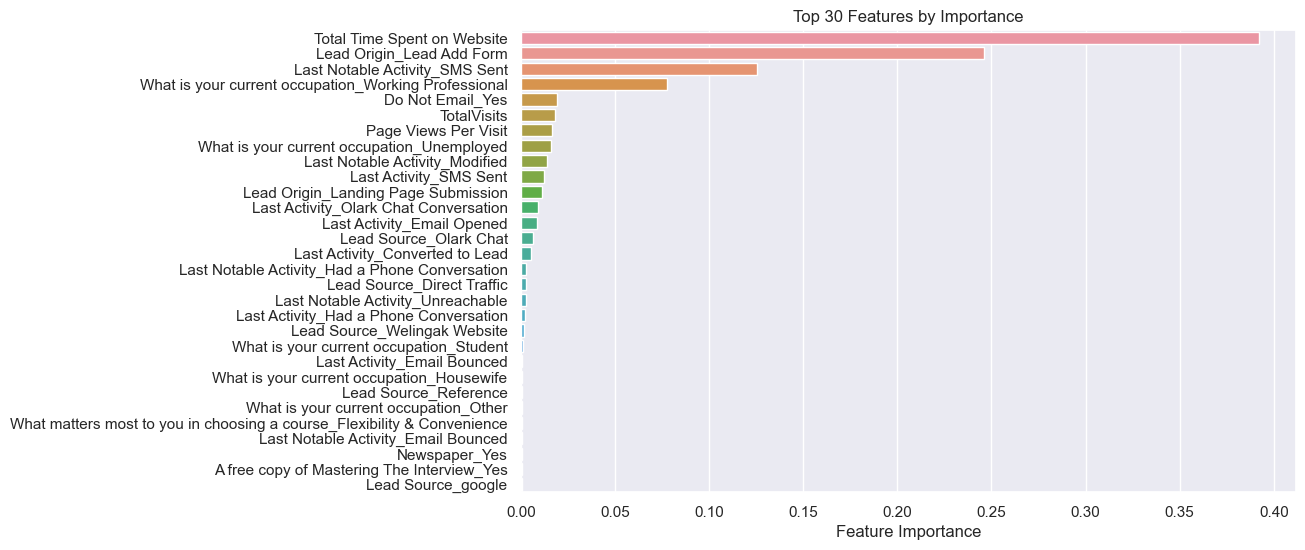

In [27]:
# Sort the feature importances and get the indices
sorted_indices = np.argsort(best_model.feature_importances_)[::-1]

# Get the feature names in the sorted order
sorted_feature_names = X.columns[sorted_indices]

# Get the corresponding sorted feature importances
sorted_feature_importances = best_model.feature_importances_[sorted_indices]

top_n = 30  # You can adjust this value
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances[:top_n], y=sorted_feature_names[:top_n], orient="h")
plt.title(f'Top {top_n} Features by Importance')
plt.xlabel('Feature Importance')
plt.show()